In [1]:
from pathlib import Path

run_id = "rog61gn4"
run_dir = Path(
    f"/net/csefiles/coc-fung-cluster/nima/shared/experiment-data/nshtrainer/{run_id}/"
)
assert (
    run_dir.exists() and run_dir.is_dir()
), f"run_dir: {run_dir} does not exist or is not a directory"
print(run_dir)

if (snapshot_dir := next(run_dir.glob("./nshrunner/snapshots/*/"), None)) is not None:
    import nshrunner

    nshrunner.load_existing_snapshot(snapshot_dir)

/net/csefiles/coc-fung-cluster/nima/shared/experiment-data/nshtrainer/rog61gn4


Added /net/csefiles/coc-fung-cluster/nima/shared/experiment-data/nshrunner/41d0be4a-1762-47f3-9ce3-e52cd9b2bd12/snapshots/20240730143647--b58fd01f-2780-4203-b600-70978a2ceb5c to sys.path. Modules: jmppeft


In [2]:
import os

os.environ["LL_DISABLE_TYPECHECKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


import torch

torch.no_grad().__enter__()
torch.inference_mode().__enter__()

device = torch.device("cuda:0")
default_dtype = torch.float32

In [3]:
from jmppeft.tasks.finetune import matbench_discovery as M

ckpt_path = (run_dir / "checkpoint" / "latest.ckpt").resolve()
model = M.MatbenchDiscoveryModel.load_checkpoint(ckpt_path, map_location=device)
model = model.to(device, dtype=default_dtype)
model

Type checking the following modules: ('jmppeft',)


TensorBoard/TensorBoardX not found. Disabling TensorBoardLogger. Please install TensorBoard with `pip install tensorboard` or TensorBoardX with `pip install tensorboardx` to enable TensorBoard logging.
NSHRUNNER_SESSION_DIR is not set. Skipping symlink creation.
NSHRUNNER_SESSION_DIR is not set. Skipping symlink creation.
NSHRUNNER_SESSION_DIR is not set. Skipping symlink creation.
NSHRUNNER_SESSION_DIR is not set. Skipping symlink creation.
Using regular backbone


Unrecognized arguments:  dict_keys(['name', 'learnable_rbf', 'learnable_rbf_stds', 'unique_basis_per_layer', 'dropout', 'edge_dropout', 'ln_per_layer', 'scale_factor_to_ln'])


Constructed backbone with dlora=None
Freezing 0 parameters (0.00%) out of 43,146,824 total parameters (43,146,824 trainable)


MatbenchDiscoveryModel(config=MatbenchDiscoveryConfig(name=mptrj-jmps-bsz40-linrefenergy-lr8e-05-ln-direct-maceenergy-maceforce-rele-ec5.0-fc10.0-sc100.0-posaug_std0.01, project=jmp_mptrj), device=cuda:0)

In [4]:
from jmppeft.tasks.finetune.base import FinetuneMatBenchDiscoveryIS2REDatasetConfig

dataset_config = FinetuneMatBenchDiscoveryIS2REDatasetConfig(
    # sample_n=DatasetSampleNConfig(sample_n=16, seed=42)
)
print(dataset_config)

dataset_og = dataset_config.create_dataset()
dataset_og, len(dataset_og)


Loading 'wbm_summary' from cached file at '/nethome/nsg6/.cache/matbench-discovery/1.0.0/wbm/2023-12-13-wbm-summary.csv.gz'


(<jmppeft.datasets.mpd_is2re.MatBenchDiscoveryIS2REDataset at 0x7ff25258a610>,
 256963)

In [5]:
from collections import Counter

import jmppeft.modules.dataset.dataset_transform as DT
import nshutils
import rich
import torch.utils._pytree as tree
from lightning.fabric.utilities.apply_func import move_data_to_device
from torch_geometric.data import Batch, Data

nshutils.pretty()


def data_transform(data: Data):
    data = model.data_transform(data)
    data = Data.from_dict(
        tree.tree_map(
            lambda x: x.type(default_dtype)
            if torch.is_tensor(x) and torch.is_floating_point(x)
            else x,
            data.to_dict(),
        )
    )
    return data


def composition(data: Batch):
    return dict(Counter(data.atomic_numbers.tolist()))


num_items = 1024

dataset = DT.transform(dataset_og, data_transform)
dataset = DT.sample_n_transform(dataset, n=num_items, seed=42)


idx = 32
data = Batch.from_data_list([dataset[idx]])
rich.print(data.to_dict(), composition(data))

{
    'pos': tensor[11, 3] n=33 x∈[-4.287, 6.937] μ=1.412 σ=2.423,
    'id': ['wbm-3-72883'],
    'atomic_numbers': tensor[11] i64 x∈[50, 79] μ=62.000 σ=14.269,
    'cell': tensor[1, 3, 3] n=9 x∈[-3.509, 6.938] μ=1.065 σ=4.112 [[[6.029, 0., -3.509], [-2.037, 5.674, -3.509], 
[0., 0., 6.938]]],
    'y_formation': tensor[1] [-0.236],
    'y_formation_correction': tensor[1] [0.],
    'y_above_hull': tensor[1] [0.093],
    'natoms': tensor[1] i64 [11],
    'pos_noise': tensor[11, 3] n=33 all_zeros,
    'tags': tensor[11] i64 x∈[2, 2] μ=2.000 σ=0.,
    'fixed': tensor[11] bool all_zeros,
    'batch': tensor[11] i64 all_zeros,
    'ptr': tensor[2] i64 μ=5.500 σ=7.778 [0, 11]
}
{66: 1, 50: 6, 79: 4}

In [6]:
import numpy as np
from jmppeft.modules.relaxer import ModelOutput, Relaxer
from matbench_discovery.energy import get_e_form_per_atom

LINREF = np.load(
    "/net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/notebooks/mptrj_linref.npy"
)


def model_fn(data, initial_data, *, use_y_relaxed: bool) -> ModelOutput:
    model_out = model.forward_denormalized(data)

    # energy = model_out["y_relaxed"] if use_y_relaxed else model_out["y"]
    energy = model_out["y"]
    relaxed_energy = model_out["y_relaxed"]
    forces = model_out["force"]
    stress = model_out["stress"]

    # Undo the linref
    if LINREF is not None:
        energy = energy + LINREF[data.atomic_numbers.cpu().numpy()].sum()
        relaxed_energy = (
            relaxed_energy + LINREF[data.atomic_numbers.cpu().numpy()].sum()
        )

    # JMP-S v2 energy is corrected_energy, i.e., DFT total energy
    # This energy is now DFT total energy, we need to convert it to formation energy per atom
    energy = get_e_form_per_atom(
        {
            "composition": composition(data),
            "energy": energy,
        }
    )
    relaxed_energy = get_e_form_per_atom(
        {
            "composition": composition(data),
            "energy": relaxed_energy,
        }
    )
    assert isinstance(energy, torch.Tensor)
    assert isinstance(relaxed_energy, torch.Tensor)

    # Add the correction factor
    if False:
        energy += initial_data.y_formation_correction.item()

    # energy, relaxed_energy = tree.tree_map(
    #     lambda energy: energy.view(1), (energy, relaxed_energy)
    # )
    energy = energy.view(1)
    relaxed_energy = relaxed_energy.view(1)
    forces = forces.view(-1, 3)
    stress = stress.view(1, 3, 3) if stress.numel() == 9 else stress.view(1, 6)

    return {
        "current_energy": energy,
        "relaxed_energy": relaxed_energy,
        "energy": relaxed_energy if use_y_relaxed else energy,
        "forces": forces,
        "stress": stress,
    }


data = move_data_to_device(data, model.device)
model_fn(data, data, use_y_relaxed=False)

{'current_energy': tensor[1] cuda:0 [0.135],
 'relaxed_energy': tensor[1] cuda:0 [-0.115],
 'energy': tensor[1] cuda:0 [0.135],
 'forces': tensor[11, 3] n=33 x∈[-0.820, 0.814] μ=-0.001 σ=0.420 cuda:0,
 'stress': tensor[1, 3, 3] n=9 x∈[-0.124, -0.002] μ=-0.043 σ=0.060 cuda:0 [[[-0.122, -0.002, -0.002], [-0.002, -0.124, -0.003], [-0.002, -0.003, -0.124]]]}

In [7]:
from functools import partial

import rich
from jmppeft.modules.relaxer import RelaxerConfig

config = RelaxerConfig(
    compute_stress=True,
    stress_weight=0.1,
    optimizer="FIRE",
    fmax=0.05,
    ase_filter="exp",
)
relaxer = Relaxer(
    config=config,
    model=partial(model_fn, use_y_relaxed=False),
    collate_fn=model.collate_fn,
    device=model.device,
)
rich.print(data.y_formation)
relax_out = relaxer.relax(data)
# rich.print(relax_out)

energy = relax_out.atoms.get_total_energy()
rich.print(energy, data.y_formation)

tensor[1] cuda:0 [-0.236]

      Step     Time          Energy          fmax
FIRE:    0 12:20:48        0.135402        2.952579
FIRE:    1 12:20:48       -0.036928        1.201562
FIRE:    2 12:20:49       -0.114881        0.468614
FIRE:    3 12:20:49       -0.115098        0.463799
FIRE:    4 12:20:49       -0.115887        0.460155
FIRE:    5 12:20:49       -0.117830        0.458473
FIRE:    6 12:20:49       -0.117868        0.437506
FIRE:    7 12:20:49       -0.117869        0.412105
FIRE:    8 12:20:50       -0.117842        0.385969
FIRE:    9 12:20:50       -0.112863        0.359343
FIRE:   10 12:20:50       -0.111781        0.333125
FIRE:   11 12:20:50       -0.112081        0.310654
FIRE:   12 12:20:50       -0.115379        0.288041
FIRE:   13 12:20:50       -0.127590        0.275256
FIRE:   14 12:20:50       -0.133358        0.258740
FIRE:   15 12:20:50       -0.139715        0.245784
FIRE:   16 12:20:51       -0.145232        0.239121
FIRE:   17 12:20:51       -0.151695        0.226325
FIRE:   18 12:

-0.19652314484119415 tensor[1] cuda:0 [-0.236]

In [8]:
import copy


def relax_and_return_structure(
    relaxer: Relaxer,
    graph: Batch,
    device: str | torch.device | None = None,
    verbose: bool = True,
):
    out_graph = copy.deepcopy(graph)
    output = relaxer.relax(graph, verbose=verbose)

    atoms = output.atoms
    # Convert the relaxed structure to a graph
    out_graph.pos = torch.tensor(
        atoms.positions,
        dtype=out_graph.pos.dtype,
        device=out_graph.pos.device,
    )
    out_graph.cell = torch.tensor(
        atoms.cell.array,
        dtype=out_graph.cell.dtype,
        device=out_graph.cell.device,
    ).reshape_as(out_graph.cell)

    out_graph.y_prediction = torch.tensor(
        atoms.get_total_energy(),
        dtype=torch.float,
        device=out_graph.pos.device,
    ).view(-1)

    if device is not None:
        out_graph = cast(Batch, move_data_to_device(out_graph, device))

    return out_graph, output

In [9]:
from collections import defaultdict
from functools import partial
from typing import TypedDict, cast

import numpy as np
from jmppeft.modules.relaxer import RelaxationOutput
from torch.utils.data import DataLoader
from torch_geometric.data import Batch
from tqdm.auto import tqdm

use_y_relaxed = True

config = RelaxerConfig(
    compute_stress=True,
    stress_weight=0.1,
    optimizer="FIRE",
    # fmax=0.01,
    # ase_filter="frechet",
    fmax=0.05,
    ase_filter="exp",
)
relaxer = Relaxer(
    config=config,
    model=partial(model_fn, use_y_relaxed=use_y_relaxed),
    collate_fn=model.collate_fn,
    device=model.device,
)

dl = DataLoader(
    dataset,
    batch_size=1,
    collate_fn=model.collate_fn,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

preds_targets = defaultdict[str, list[tuple[float, float]]](lambda: [])
mae_error = 0.0
mae_count = 0


class ProblematicSample(TypedDict):
    error: float
    initial_data: Batch
    relaxed_data: Batch
    relax_out: RelaxationOutput


problematic_samples: list[ProblematicSample] = []
ae_threshold = 0.1

for data in tqdm(dl, total=len(dl)):
    data = cast(Batch, data)
    data = move_data_to_device(data, model.device)
    data.y_prediction = data.y_formation
    relaxed_data, relax_out = relax_and_return_structure(relaxer, data, verbose=False)

    e_form_true = data.y_formation.item()
    e_form_pred = relax_out.atoms.get_total_energy()
    preds_targets["e_form"].append((e_form_pred, e_form_true))

    e_above_hull_true = data.y_above_hull.item()
    e_above_hull_pred = e_above_hull_true + (e_form_pred - e_form_true)
    preds_targets["e_above_hull"].append((e_above_hull_pred, e_above_hull_true))

    mae_error += abs(e_form_pred - e_form_true)
    mae_count += 1
    mae_running = mae_error / mae_count

    nsteps = len(relax_out.trajectory.frames)

    error = abs(e_form_pred - e_form_true)
    prefix = "✅"
    if error > ae_threshold:
        problematic_samples.append(
            {
                "error": error,
                "initial_data": move_data_to_device(data, "cpu"),
                "relaxed_data": move_data_to_device(relaxed_data, "cpu"),
                "relax_out": move_data_to_device(relax_out, "cpu"),
            }
        )
        prefix = "❌"

    print(
        f"{prefix} # Steps: {nsteps}; e_form: P={e_form_pred:.4f}, GT={e_form_true:.4f}, Δ={abs(e_form_pred - e_form_true):.4f}, MAE={mae_running:.4f}"
    )

  0%|          | 0/1024 [00:00<?, ?it/s]

✅ # Steps: 20; e_form: P=-0.8565, GT=-0.8008, Δ=0.0557, MAE=0.0557
✅ # Steps: 20; e_form: P=0.0053, GT=-0.0220, Δ=0.0273, MAE=0.0415
✅ # Steps: 11; e_form: P=-0.5985, GT=-0.6088, Δ=0.0102, MAE=0.0311
✅ # Steps: 44; e_form: P=-0.1902, GT=-0.1544, Δ=0.0358, MAE=0.0322
❌ # Steps: 56; e_form: P=-0.2731, GT=-0.1154, Δ=0.1577, MAE=0.0573
✅ # Steps: 18; e_form: P=-0.3801, GT=-0.3905, Δ=0.0103, MAE=0.0495
✅ # Steps: 12; e_form: P=-0.2392, GT=-0.2468, Δ=0.0076, MAE=0.0435
✅ # Steps: 16; e_form: P=-0.5418, GT=-0.4542, Δ=0.0876, MAE=0.0490
✅ # Steps: 11; e_form: P=-1.9549, GT=-1.9089, Δ=0.0460, MAE=0.0487
✅ # Steps: 6; e_form: P=-0.1521, GT=-0.1224, Δ=0.0298, MAE=0.0468
✅ # Steps: 4; e_form: P=-1.8769, GT=-1.8781, Δ=0.0012, MAE=0.0426
✅ # Steps: 13; e_form: P=-1.5886, GT=-1.6101, Δ=0.0214, MAE=0.0409
✅ # Steps: 15; e_form: P=-1.8900, GT=-1.8180, Δ=0.0720, MAE=0.0433
✅ # Steps: 4; e_form: P=-0.3360, GT=-0.3333, Δ=0.0028, MAE=0.0404
✅ # Steps: 14; e_form: P=-0.7610, GT=-0.7299, Δ=0.0311, MAE=0.0398

In [10]:
import ase
import ase.visualize
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme()


class UpdatedProblematicSample(TypedDict):
    error: float
    initial_data: Batch
    relaxed_data: Batch
    relax_out: RelaxationOutput

    s2e_energies: list[float]
    s2re_energies: list[float]


def _update_sample(sample: ProblematicSample) -> UpdatedProblematicSample:
    relax_out = sample["relax_out"]

    initial_data = move_data_to_device(
        copy.deepcopy(sample["initial_data"]), model.device
    )
    data = move_data_to_device(copy.deepcopy(sample["initial_data"]), model.device)

    s2e_energies = []
    s2re_energies = []
    for f in tqdm(relax_out.trajectory.frames):
        data.pos = f.pos.type_as(data.pos).reshape_as(data.pos).to(data.pos.device)
        data.cell = f.cell.type_as(data.cell).reshape_as(data.cell).to(data.cell.device)

        out = model_fn(data, initial_data, use_y_relaxed=True)
        # yield out["energy"].item()
        s2e_energies.append(out["current_energy"].item())
        s2re_energies.append(out["relaxed_energy"].item())

    return {**sample, "s2e_energies": s2e_energies, "s2re_energies": s2re_energies}


def plot_energy_vs_steps(sample: UpdatedProblematicSample, ax: plt.Axes | None = None):
    initial_data = sample["initial_data"]

    e_form_true = initial_data.y_formation.item()

    if ax is None:
        _, ax = plt.subplots()
    ax.plot(sample["s2e_energies"], label="S2E Pred")
    ax.plot(sample["s2re_energies"], label="S2RE Pred")
    ax.axhline(y=e_form_true, color="r", linestyle="--", label="True")

    ax.set_xlabel("Step")
    ax.set_ylabel("Formation Energy")
    ax.legend()

    return ax


def plot_initial_structure(sample: ProblematicSample):
    initial_data = sample["initial_data"]
    atoms = ase.Atoms(
        numbers=initial_data.atomic_numbers.cpu().numpy(),
        positions=initial_data.pos.cpu().numpy(),
        cell=initial_data.cell.cpu().squeeze(0).numpy(),
        pbc=[True, True, True],
    )

    return ase.visualize.view(atoms, viewer="ngl")


def plot_trajectory(sample: ProblematicSample):
    initial_data = move_data_to_device(copy.deepcopy(sample["initial_data"]), "cpu")
    atoms_list = [
        ase.Atoms(
            numbers=initial_data.atomic_numbers.cpu().numpy(),
            positions=f.pos.cpu().numpy(),
            cell=f.cell.cpu().squeeze(0).numpy(),
            pbc=[True, True, True],
        )
        for f in sample["relax_out"].trajectory.frames
    ]

    return ase.visualize.view(atoms_list, viewer="ngl")


def debug_system(idx: int, figsize: tuple[int, int] = (3, 2)):
    sample = problematic_samples[idx]
    updated_sample = _update_sample(sample)

    # display(plot_initial_structure(updated_sample))
    display(plot_trajectory(updated_sample))

    fig, ax = plt.subplots(figsize=figsize)
    plot_energy_vs_steps(updated_sample, ax=ax)
    plt.show()

Max error index: 47, error: 0.6903281807899475


  0%|          | 0/9 [00:00<?, ?it/s]

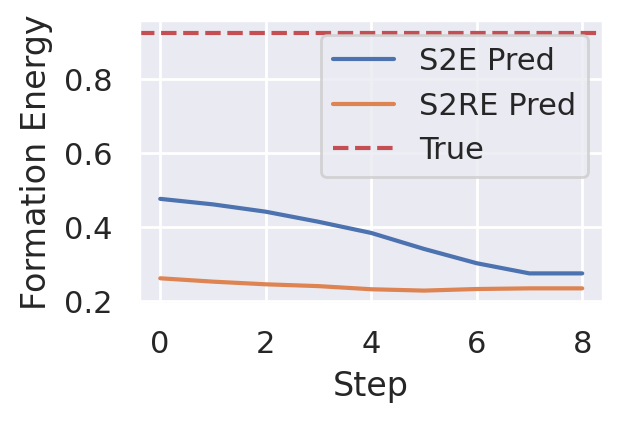

In [11]:
max_error_idx = np.argmax([s["error"] for s in problematic_samples])
print(
    f"Max error index: {max_error_idx}, error: {problematic_samples[max_error_idx]['error']}"
)
debug_system(max_error_idx)

index: 6, error: 0.27349376678466797


  0%|          | 0/21 [00:00<?, ?it/s]

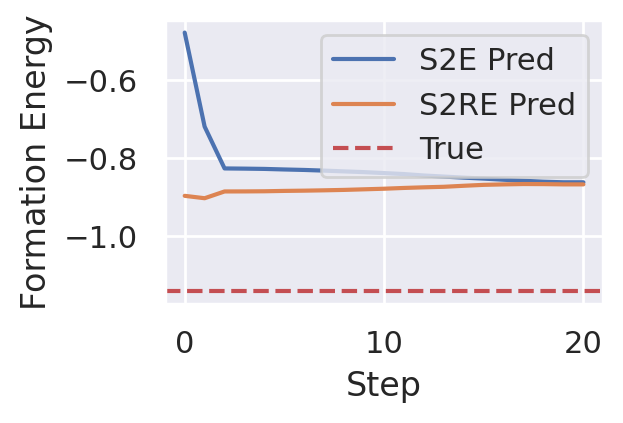

In [12]:
idx = 10
max_error_idx = np.argsort([s["error"] for s in problematic_samples])[-idx]
print(f"index: {max_error_idx}, error: {problematic_samples[max_error_idx]['error']}")
debug_system(max_error_idx)

index: 25, error: 0.25337085127830505


  0%|          | 0/7 [00:00<?, ?it/s]

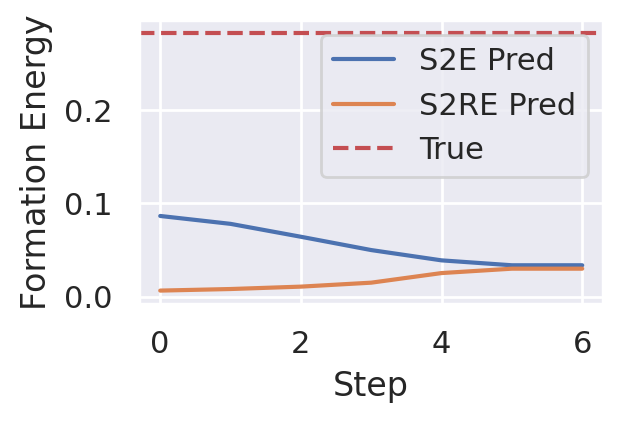

In [13]:
idx = 12
max_error_idx = np.argsort([s["error"] for s in problematic_samples])[-idx]
print(f"index: {max_error_idx}, error: {problematic_samples[max_error_idx]['error']}")
debug_system(max_error_idx)

In [14]:
# Sort by error
problematic_samples_sorted = sorted(
    problematic_samples,
    key=lambda x: len(x["relax_out"].trajectory.frames),
    reverse=True,
)
for i, sample in enumerate(problematic_samples_sorted):
    print(
        f"Index: {i}, Error: {sample['error']:.4f}, # Steps: {len(sample['relax_out'].trajectory.frames)}"
    )
    display(plot_trajectory(sample))

    if i == 10:
        break

Index: 0, Error: 0.1051, # Steps: 100


Index: 1, Error: 0.4876, # Steps: 74


Index: 2, Error: 0.1577, # Steps: 56


Index: 3, Error: 0.1705, # Steps: 50


Index: 4, Error: 0.1532, # Steps: 47


Index: 5, Error: 0.4786, # Steps: 46


Index: 6, Error: 0.1669, # Steps: 44


Index: 7, Error: 0.1032, # Steps: 36


Index: 8, Error: 0.1280, # Steps: 35


Index: 9, Error: 0.1872, # Steps: 29


Index: 10, Error: 0.3945, # Steps: 26


In [15]:
datas_to_export = []

# Sort by error
problematic_samples_sorted = sorted(
    problematic_samples,
    key=lambda x: len(x["relax_out"].trajectory.frames),
    reverse=True,
)
for i, sample in enumerate(tqdm(problematic_samples_sorted)):
    updated_sample = _update_sample(sample)

    datas_to_export.append(
        {
            "s2e_energies": updated_sample["s2e_energies"],
            "s2re_energies": updated_sample["s2re_energies"],
            "atoms": [
                ase.Atoms(
                    numbers=updated_sample["initial_data"].atomic_numbers.cpu().numpy(),
                    positions=f.pos.cpu().numpy(),
                    cell=f.cell.cpu().squeeze(0).numpy(),
                    pbc=[True, True, True],
                ).todict()
                for f in updated_sample["relax_out"].trajectory.frames
            ],
        }
    )

rich.print(len(datas_to_export), datas_to_export[0])

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

75
{
    's2e_energies': [
        -1.8086813688278198,
        -1.8169294595718384,
        -1.8296312093734741,
        -1.836044192314148,
        -1.8361135721206665,
        -1.8362520933151245,
        -1.8364572525024414,
        -1.8367300033569336,
        -1.8370698690414429,
        -1.837475061416626,
        -1.8379637002944946,
        -1.8385915756225586,
        -1.8394033908843994,
        -1.8404474258422852,
        -1.8417733907699585,
        -1.8434289693832397,
        -1.8456095457077026,
        -1.8473871946334839,
        -1.8486651182174683,
        -1.8484324216842651,
        -1.8478444814682007,
        -1.842045783996582,
        -1.8281049728393555,
        -1.803929328918457,
        -1.7695330381393433,
        -1.7454336881637573,
        -1.7268999814987183,
        -1.698592185974121,
        -1.6971772909164429,
        -1.6957117319107056,
        -1.6870272159576416,
        -1.673172950744629,
        -1.655193567276001,
        -1.635716438293457,
        -1.6184580326080322,
        -1.6050852537155151,
        -1.594605803489685,
        -1.5784796476364136,
        -1.5429308414459229,
        -1.5365732908248901,
        -1.5606294870376587,
        -1.566099762916565,
        -1.5495222806930542,
        -1.5822409391403198,
        -1.5869524478912354,
        -1.558292269706726,
        -1.5174280405044556,
        -1.5731394290924072,
        -1.6674093008041382,
        -1.7313123941421509,
        -1.7767289876937866,
        -1.7678278684616089,
        -1.718652606010437,
        -1.7592958211898804,
        -1.7701205015182495,
        -1.7721757888793945,
        -1.7749003171920776,
        -1.776015281677246,
        -1.7743093967437744,
        -1.7704527378082275,
        -1.7705286741256714,
        -1.7706743478775024,
        -1.7708780765533447,
        -1.771122932434082,
        -1.7713278532028198,
        -1.7714849710464478,
        -1.7717485427856445,
        -1.7719210386276245,
        -1.772076964378357,
        -1.7721372842788696,
        -1.7720708847045898,
        -1.771897315979004,
        -1.7715567350387573,
        -1.771044373512268,
        -1.7704222202301025,
        -1.7698110342025757,
        -1.7692644596099854,
        -1.7699228525161743,
        -1.7705503702163696,
        -1.7720907926559448,
        -1.7747091054916382,
        -1.7779043912887573,
        -1.7825502157211304,
        -1.7887521982192993,
        -1.7962286472320557,
        -1.8042749166488647,
        -1.819384217262268,
        -1.8414255380630493,
        -1.8617002964019775,
        -1.883400559425354,
        -1.8919801712036133,
        -1.8980318307876587,
        -1.906022071838379,
        -1.9113714694976807,
        -1.9203428030014038,
        -1.9321672916412354,
        -1.934799075126648,
        -1.9356950521469116,
        -1.9345072507858276,
        -1.9345072507858276
    ],
    's2re_energies': [
        -1.8227919340133667,
        -1.8239649534225464,
        -1.8252683877944946,
        -1.8288129568099976,
        -1.8288843631744385,
        -1.8290274143218994,
        -1.8292436599731445,
        -1.8295351266860962,
        -1.8299044370651245,
        -1.83035147190094,
        -1.8308862447738647,
        -1.8315752744674683,
        -1.8324568271636963,
        -1.8335695266723633,
        -1.834946632385254,
        -1.836652159690857,
        -1.8390158414840698,
        -1.8407236337661743,
        -1.8419710397720337,
        -1.8421624898910522,
        -1.8449457883834839,
        -1.8503550291061401,
        -1.8614294528961182,
        -1.8792356252670288,
        -1.9013712406158447,
        -1.9127558469772339,
        -1.9161814451217651,
        -1.9366514682769775,
        -1.9362581968307495,
        -1.9331430196762085,
        -1.9343080520629883,
        -1.9371957778930664,
        -1.9363783597946167,
        -1.9402334690093994,
        -1.9423331022262573,
        -1.9416178464889526,
        -1.94299495220184

In [20]:
# Forgot to add the true formation energy, true above hull energy, and error

datas_to_export_with_true = []
for sample, data in zip(problematic_samples_sorted, datas_to_export):
    data["true_formation_energy"] = sample["initial_data"].y_formation.item()
    data["true_above_hull_energy"] = sample["initial_data"].y_above_hull.item()
    data["error"] = abs(data["true_formation_energy"] - data["s2re_energies"][-1])
    np.testing.assert_allclose(data["error"], sample["error"], rtol=1e-4, atol=1e-4)

    datas_to_export_with_true.append(data)

In [21]:
import pickle

with open("problematic_samples.relaxdata.pkl", "wb") as f:
    pickle.dump(datas_to_export_with_true, f)

# print the file size
!ls -lh problematic_samples.relaxdata.pkl

-rw-r--r-- 1 nsg6 coc-fung-cluster-access 645K Jul 31 13:43 problematic_samples.relaxdata.pkl
